In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import h5py
import os.path

import image_proc
import gt_io

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from craft.craft import CRAFT

import time

In [3]:
class SynthCharMapDataset(Dataset):
    """SynthText Dataset + Heatmap + Direction Ground Truths"""

    def __init__(self, gt_path, img_dir, color_flag=1, #transform=None,
                 character_map=True, affinity_map=True, word_map=True,
                 direction_map=True,
                 begin=0, cuda=True):
        """
        Args:
            gt_path (string): Path to gt.mat file (GT file)
            img_dir (string): Path to directory of {i}/....jpg (folders of images)

            color_flag {1,0,-1}: Colored (1), Grayscale (0), or Unchanged (-1)
        """
        super(SynthCharMapDataset).__init__()

        # paths
        self.gt_path = gt_path
        self.img_dir = img_dir
        
        # flags
        self.color_flag = color_flag
        self.character_map = character_map
        self.affinity_map = affinity_map
        self.word_map = word_map
        self.direction_map = direction_map

        self.f = h5py.File(gt_path, 'r')
        self.length = len(self.f['imnames'])
        
        self.begin = 0
        if begin > 0:
            self.begin = begin
            self.length -= begin
        
        if cuda:
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # if changing starting index
        idx += self.begin

        f = self.f
        imgname = image_proc.u2ToStr(f[f['imnames'][idx][0]])
        charBBs = f[f['charBB'][idx][0]]
        wordBBs = f[f['wordBB'][idx][0]]
        txts    = f[f['txt'][idx][0]]

        imgpath = os.path.join(self.img_dir, imgname)
        synthetic_image = cv2.imread(imgpath, self.color_flag)# HWC
        image_shape = synthetic_image.shape[0:2]
        synthetic_image = torch.from_numpy(synthetic_image).type(self.dtype).permute(2,0,1)# CHW

        
        char_map, aff_map = image_proc.genPseudoGT(charBBs, txts, image_shape,
                                                   generate_affinity=self.affinity_map)
        if self.word_map:
            word_map = image_proc.genWordGT(wordBBs, image_shape)
        if self.direction_map:
            cos_map, sin_map  = image_proc.genDirectionGT(charBBs, image_shape, normalize=True)

        
        gt = None
        if self.character_map:
            gt = char_map[None,...]
        if self.affinity_map:
            affinity_map = aff_map[None,...]
            if gt is None:
                gt = affinity_map
            else:
                gt = np.concatenate((gt, affinity_map))
        if self.word_map:
            word_map = word_map[None,...]
            if gt is None:
                gt = word_map
            else:
                gt = np.concatenate((gt, word_map))
        if self.direction_map:
            dir_map = np.stack((cos_map, sin_map))
            if gt is None:
                gt = dir_map
            else:
                gt = np.concatenate((gt, dir_map))


        # resize to match feature map size
        # to match expectations of F.interpolate, we reshape to NCHW
        gt = torch.from_numpy(gt[None,...]).type(self.dtype)
        gt_resized = F.interpolate(gt, scale_factor=0.5)[0].permute(1,2,0)# HWC
        
        #synthetic_image = self.transform(synthetic_image)
        synthetic_image = synthetic_image / 255.0
        
        return synthetic_image, gt_resized

In [4]:
gt_path = "/home/eee198/Downloads/SynthText/gt_v7.3.mat"#"/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/gt_v7.3.mat"
img_dir = "/home/eee198/Downloads/SynthText/images"#"/media/aerjay/Acer/Users/Aerjay/Downloads/SynthText/SynthText"

begin = 0#22399

# remember requires_grad=True
# SET SIGMOID TO FALSE IF USING DIRECTION MAP
dataset = SynthCharMapDataset(gt_path, img_dir, affinity_map=False, direction_map=True, word_map=True,
                              begin=begin, cuda=True)
train, test = torch.utils.data.random_split(dataset, [800000,58750])
dataloader = DataLoader(train, batch_size=1, shuffle=True)

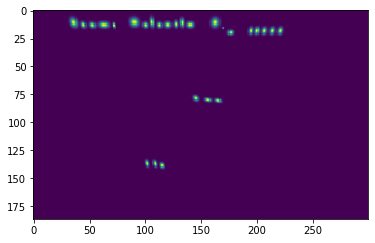

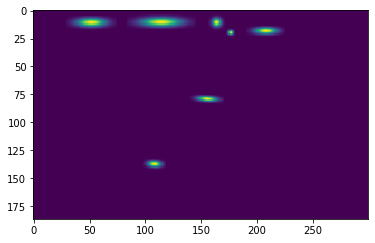

In [5]:
img, gt = dataset[51100]#[73454]

plt.figure()
plt.imshow(gt.cpu().permute(2,0,1)[0])
plt.figure()
plt.imshow(gt.cpu().permute(2,0,1)[1])
# plt.figure()
# plt.imshow(gt.cpu().permute(2,0,1)[2])

In [6]:
# input: NCHW
# output: NHWC
model = CRAFT(pretrained=True, num_class=4).cuda()

# weight_path = "/home/eee198/Downloads/SynthText/weights/w_10000"
# model.load_state_dict(torch.load(weight_path))
# model.eval()

In [15]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [16]:
T_save = 10000
T = 100
epochs = 1
start = time.time()

for epoch in range(epochs):
    running_loss = 0.0
    while(True):
        try:
            for i, (img, target) in enumerate(dataloader):
                #print(f"image shape = {img.shape}")
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output, _ = model(img)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % T == T-1:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %f' % (epoch + 1, i + 1, running_loss/T))
                    running_loss = 0.0
                if i % T_save == T_save-1:
                    print(f"\nsaving at {i}-th batch'\n")
                    torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/w_{i}_.pth")
                    end = time.time()
                    print(f"\nElapsed time: {end-start}")

            break
        except MemoryError:
            print("Memory Error")
            continue
        except AttributeError:
            print("Attribute Error")
        except KeyboardInterrupt:
            print(f"\nsaving at {i}-th batch'\n")
            torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/w_{i}_interrupt.pth")
            end = time.time()
            print(f"\nElapsed time: {end-start}")



print("Finished training.")

end = time.time()
print(f"\nTotal elapsed time: {end-start}")
#24700

[1,   100] loss: 0.009956
[1,   200] loss: 0.008496
[1,   300] loss: 0.007831
[1,   400] loss: 0.007238
[1,   500] loss: 0.008805
[1,   600] loss: 0.006761
[1,   700] loss: 0.007427
[1,   800] loss: 0.007616
[1,   900] loss: 0.008474
[1,  1000] loss: 0.007605
[1,  1100] loss: 0.008601
[1,  1200] loss: 0.007103
[1,  1300] loss: 0.006918
[1,  1400] loss: 0.008999
[1,  1500] loss: 0.006995
[1,  1600] loss: 0.007331
[1,  1700] loss: 0.007507
[1,  1800] loss: 0.007262
[1,  1900] loss: 0.007532
[1,  2000] loss: 0.007677
[1,  2100] loss: 0.008279
[1,  2200] loss: 0.007487
[1,  2300] loss: 0.008606
[1,  2400] loss: 0.007795
[1,  2500] loss: 0.007840
[1,  2600] loss: 0.007538
[1,  2700] loss: 0.007456
[1,  2800] loss: 0.008869
[1,  2900] loss: 0.008362
[1,  3000] loss: 0.007993
[1,  3100] loss: 0.008252
[1,  3200] loss: 0.007537
[1,  3300] loss: 0.007639
[1,  3400] loss: 0.007820
[1,  3500] loss: 0.008192
[1,  3600] loss: 0.007238
[1,  3700] loss: 0.008002
[1,  3800] loss: 0.007294
[1,  3900] l

[1, 31000] loss: 0.007667
[1, 31100] loss: 0.007028
[1, 31200] loss: 0.007431
[1, 31300] loss: 0.007354
[1, 31400] loss: 0.006628
[1, 31500] loss: 0.006066
[1, 31600] loss: 0.007043
[1, 31700] loss: 0.006909
[1, 31800] loss: 0.007574
[1, 31900] loss: 0.006805
[1, 32000] loss: 0.007088
[1, 32100] loss: 0.006660
[1, 32200] loss: 0.007648
[1, 32300] loss: 0.007354
[1, 32400] loss: 0.006121
[1, 32500] loss: 0.007128
[1, 32600] loss: 0.006185
[1, 32700] loss: 0.006806
[1, 32800] loss: 0.007273
[1, 32900] loss: 0.007140
[1, 33000] loss: 0.007424
[1, 33100] loss: 0.006393
[1, 33200] loss: 0.007318
[1, 33300] loss: 0.005979
[1, 33400] loss: 0.007360
[1, 33500] loss: 0.006820
[1, 33600] loss: 0.007450
[1, 33700] loss: 0.006905
[1, 33800] loss: 0.006528
[1, 33900] loss: 0.006374
[1, 34000] loss: 0.007274
[1, 34100] loss: 0.005807
[1, 34200] loss: 0.007214
[1, 34300] loss: 0.006031
[1, 34400] loss: 0.006432
[1, 34500] loss: 0.006666
[1, 34600] loss: 0.007946
[1, 34700] loss: 0.006077
[1, 34800] l

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/imgwarp.cpp:1728: error: (-215:Assertion failed) dst.cols < 0x7fff && dst.rows < 0x7fff && src.cols < 0x7fff && src.rows < 0x7fff in function 'remap'


In [9]:
torch.save(model.state_dict(), f"/home/eee198/Downloads/SynthText/weights/w_{i}_AttributeError_NoneType.shape.pth")

In [7]:
img, gt = None, None
for im,g in dataloader:
    print(f"g.size() = {g.size()}")
    img, gt = im, g
    break
img1, gt1 = img.clone(), gt.clone()

g.size() = torch.Size([1, 199, 300, 1])


In [8]:
# testing for overfitting
T = 100
N = 10000
for i in range(N):
    running_loss = 0.0
    
    optimizer.zero_grad()
    
    output,_ = model(img)
    loss = criterion(output, gt)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % T == T-1:
        print('[%d] loss: %f' % (i + 1, running_loss/T))
        running_loss = 0.0

[100] loss: 0.000869
[200] loss: 0.000427
[300] loss: 0.000236
[400] loss: 0.000154
[500] loss: 0.000113
[600] loss: 0.000090
[700] loss: 0.000076
[800] loss: 0.000067
[900] loss: 0.000060
[1000] loss: 0.000055
[1100] loss: 0.000051
[1200] loss: 0.000048
[1300] loss: 0.000046
[1400] loss: 0.000044
[1500] loss: 0.000042
[1600] loss: 0.000040
[1700] loss: 0.000039
[1800] loss: 0.000038
[1900] loss: 0.000037
[2000] loss: 0.000036
[2100] loss: 0.000035
[2200] loss: 0.000034
[2300] loss: 0.000034
[2400] loss: 0.000033
[2500] loss: 0.000032
[2600] loss: 0.000032
[2700] loss: 0.000031
[2800] loss: 0.000031
[2900] loss: 0.000030
[3000] loss: 0.000030
[3100] loss: 0.000030
[3200] loss: 0.000029
[3300] loss: 0.000029
[3400] loss: 0.000028
[3500] loss: 0.000028
[3600] loss: 0.000028
[3700] loss: 0.000027
[3800] loss: 0.000027
[3900] loss: 0.000027
[4000] loss: 0.000026
[4100] loss: 0.000026
[4200] loss: 0.000026
[4300] loss: 0.000025
[4400] loss: 0.000025
[4500] loss: 0.000025
[4600] loss: 0.0000

In [7]:
model.load_state_dict(torch.load(f"/home/eee198/Downloads/SynthText/weights/w_74229_AttributeError_NoneType.shape.pth"))
model.eval()

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, 

In [9]:
img1, gt1 = img.clone(), gt.clone()
print("image shape: ", img1.shape)
print("gt shape: ", gt1.shape)

image shape:  torch.Size([1, 3, 399, 600])
gt shape:  torch.Size([1, 199, 300, 1])


In [11]:
img, gt = dataset[1]
# print(f"min(img) = {torch.min(img)}\nmin(gt) = {torch.min(gt)}")
# print(f"max(img) = {torch.max(img)}\nmax(gt) = {torch.max(gt)}")

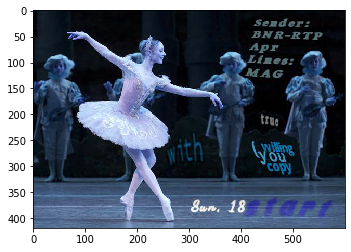

In [13]:
plt.figure()
x = (img.permute(1,2,0))*255
plt.imshow(x.cpu().int())

gt shape = torch.Size([199, 300, 1])
shape = torch.Size([199, 300])


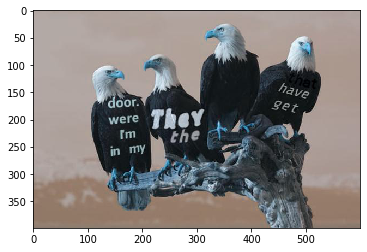

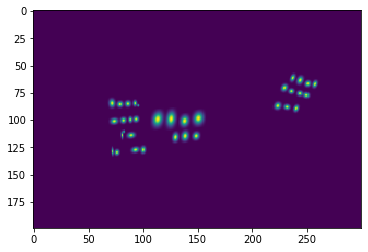

In [10]:
plt.figure()
x = (img1[0].permute(1,2,0))*255
plt.imshow(x.cpu().numpy().astype('int'))

gt_shape = gt1[0].size()
print(f"gt shape = {gt_shape}")
gt = gt1[0].view([gt_shape[2],gt_shape[0],gt_shape[1]])
for map in gt:
    print(f"shape = {map.size()}")
    plt.figure()
    plt.imshow(map.cpu().numpy())

In [ ]:
img, gt = None, None
for img, gt in dataloader:
    image = img[0].permute(1,2,0).cpu().numpy()
    image.shape
    plt.imshow(image)
    break

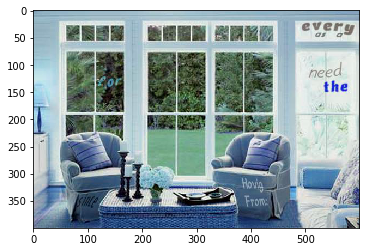

In [17]:
img, gt = None, None
for img, gt in dataloader:
    image = img[0].permute(1,2,0).cpu().numpy()
    image.shape
    plt.imshow(image)
    break

In [18]:
print("input shape: ", end="")
print(img.shape)
output, _ = model(img)
print("output shape: ", end="")
print(output.shape)

input shape: torch.Size([1, 3, 400, 600])
output shape: torch.Size([1, 200, 300, 4])


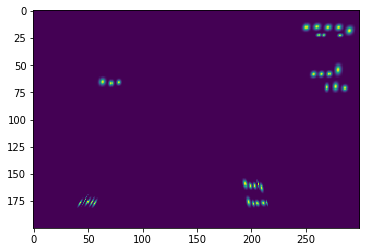

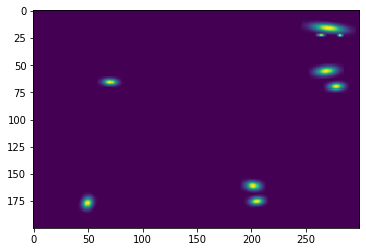

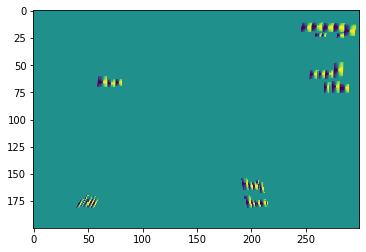

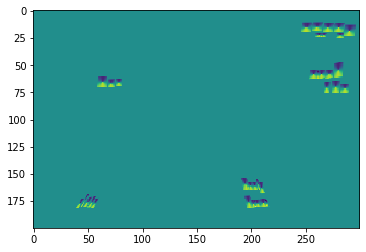

In [24]:
plt.figure()
gt_out = gt[0].permute(2,0,1).cpu().detach().numpy()[0]
plt.imshow(gt_out)

plt.figure()
gt_out = gt[0].permute(2,0,1).cpu().detach().numpy()[1]
plt.imshow(gt_out)

plt.figure()
gt_out = gt[0].permute(2,0,1).cpu().detach().numpy()[2]
plt.imshow(gt_out)

plt.figure()
gt_out = gt[0].permute(2,0,1).cpu().detach().numpy()[3]
plt.imshow(gt_out)

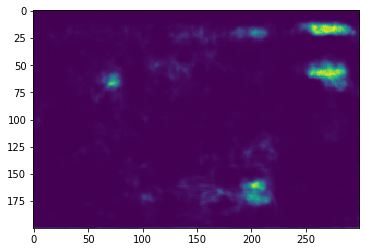

In [20]:
img_out = output[0].permute(2,0,1).cpu().detach().numpy()[0]
plt.imshow(img_out)

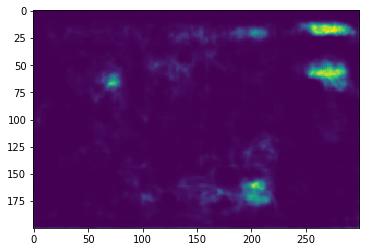

In [21]:
img_out = output[0].permute(2,0,1).cpu().detach().numpy()[1]
plt.imshow(img_out)

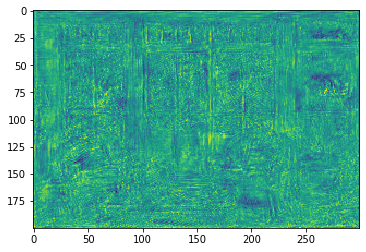

In [22]:
img_out = output[0].permute(2,0,1).cpu().detach().numpy()[2]
plt.imshow(img_out)

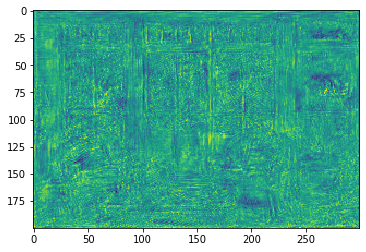

In [23]:
img_out = output[0].permute(2,0,1).cpu().detach().numpy()[2]
plt.imshow(img_out)

In [31]:
print(np.max(img_out), np.min(img_out))

0.22952314 2.6491716e-06
